# Overssampling
**we will be using most performing model selected in FD_Supervised.ipynb. This time,howeve, we'll be over/under-sampling our dataset to deal with our unbalanced data.**

In [2]:
import numpy as np
import sklearn as sk
import pandas as pd
import seaborn as sns
%matplotlib inline


In [3]:
##metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
## data Loading
df = pd.read_csv('C:/Users/VonGola/Downloads/Compressed/creditcard.csv', low_memory=False)
df.head()
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)
## we're dropping features that depicts extremely similar distributions of data for both fraud and valid transactions
## As it won't provide any help for our models, and may in fact be only a noise that cloud the signal

In [5]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(len(train))
print(len(validate))
print(len(test))
df=train

170884
56961
56962


In [6]:
df.Class.value_counts()

0    170589
1       295
Name: Class, dtype: int64

In [8]:
model_variables = ['Time', 'V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12',
                   'V14','V16','V17','V18','V19','V21','Amount', 'Class']

df_data_relevent = df[model_variables]

In [9]:
from sklearn.model_selection import train_test_split
training_features, test_features, \
training_target, test_target, = train_test_split(df_data_relevent.drop(['Class'], axis=1),
                                               df_data_relevent['Class'],
                                               test_size = .2,
                                               random_state=12)

In [10]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio =0.15,k_neighbors=4)
x_res, y_res = sm.fit_sample(training_features, training_target)
print (training_target.value_counts())
print(np.bincount(y_res))

c:\users\vongola\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


0    136472
1       235
Name: Class, dtype: int64
[136472  20470]


In [11]:
X2, X, y2, y = train_test_split(x_res,y_res,test_size = .3,random_state=12)

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(bootstrap=False,class_weight='balanced',criterion='entropy',random_state=7,n_estimators=50)
rf.fit(X2,y2)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

In [13]:
from sklearn import metrics
y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)

predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X2) - (false_neg + false_pos)) / len(X2)
print("Accuracy:", accuracy)

print("Total test data points:", len(X2))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)

Accuracy: 0.999827051038149
Total test data points: 109859
TP  6006
FP  7
TN  41058
FN  12
BCR : BALANCED CLASSIFICATION RATE  0.9989177602951526
total fraud  6018
total legit  41065
Recall; percentage of detected fraud  0.9980059820538385
false alarm rate  0.00017046146353342262


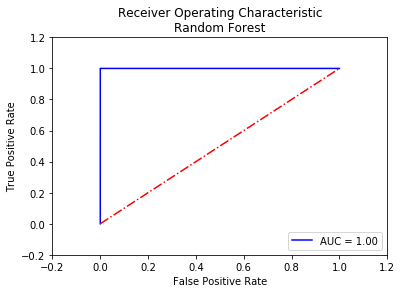

In [14]:
import matplotlib.pyplot as plt
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

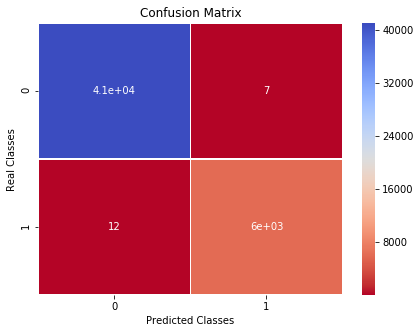

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     41065
          1       1.00      1.00      1.00      6018

avg / total       1.00      1.00      1.00     47083



In [15]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))


PlotConfusionMatrix(y,predictions,real_good,real_fraud)

In [16]:
X = test.iloc[:,:-1]
y= test['Class']
from sklearn import metrics
import matplotlib.pyplot as plt
y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)

predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X2) - (false_neg + false_pos)) / len(X2)
print("Accuracy:", accuracy)

print("Total test data points:", len(X2))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)

Accuracy: 0.9997178201148745
Total test data points: 109859
TP  81
FP  14
TN  56850
FN  17
BCR : BALANCED CLASSIFICATION RATE  0.9131422053908789
total fraud  98
total legit  56864
Recall; percentage of detected fraud  0.826530612244898
false alarm rate  0.0002462014631401238


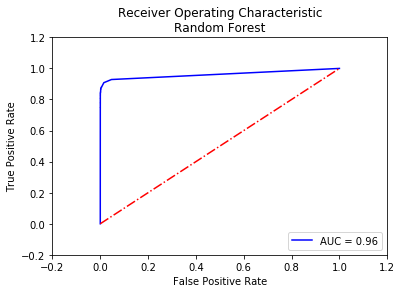

In [17]:
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Average precision-recall score: 0.82


Text(0.5,1,'2-class Precision-Recall curve: AP=0.82')

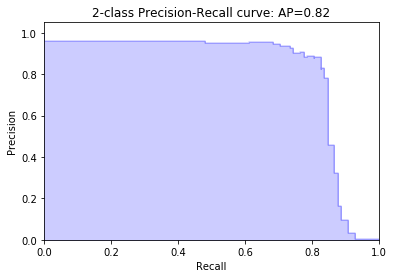

In [18]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y,y_rf_prob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y,y_rf_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

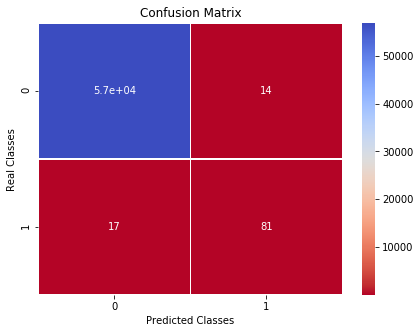

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.85      0.83      0.84        98

avg / total       1.00      1.00      1.00     56962



In [19]:
PlotConfusionMatrix(y,predictions,real_good,real_fraud)

In [20]:
## test 2
X=validate.iloc[:,:-1]
y=validate['Class']

y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)

predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X2) - (false_neg + false_pos)) / len(X2)
print("Accuracy:", accuracy)

print("Total test data points:", len(X2))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)


Accuracy: 0.9997815381534513
Total test data points: 109859
TP  86
FP  11
TN  56851
FN  13
BCR : BALANCED CLASSIFICATION RATE  0.934246708938067
total fraud  99
total legit  56862
Recall; percentage of detected fraud  0.8686868686868687
false alarm rate  0.00019345081073476135


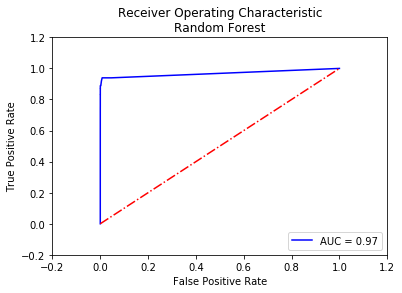

In [21]:
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Average precision-recall score: 0.88


Text(0.5,1,'2-class Precision-Recall curve: AP=0.88')

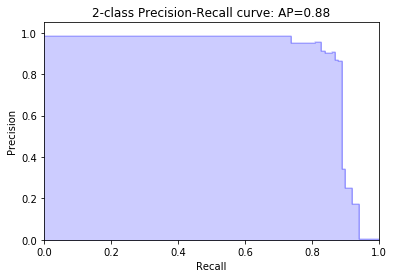

In [22]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y,y_rf_prob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y,y_rf_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

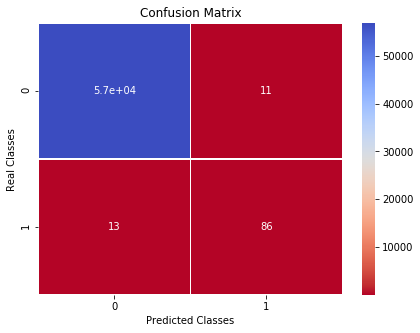

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56862
          1       0.89      0.87      0.88        99

avg / total       1.00      1.00      1.00     56961



In [23]:
PlotConfusionMatrix(y,predictions,real_good,real_fraud)

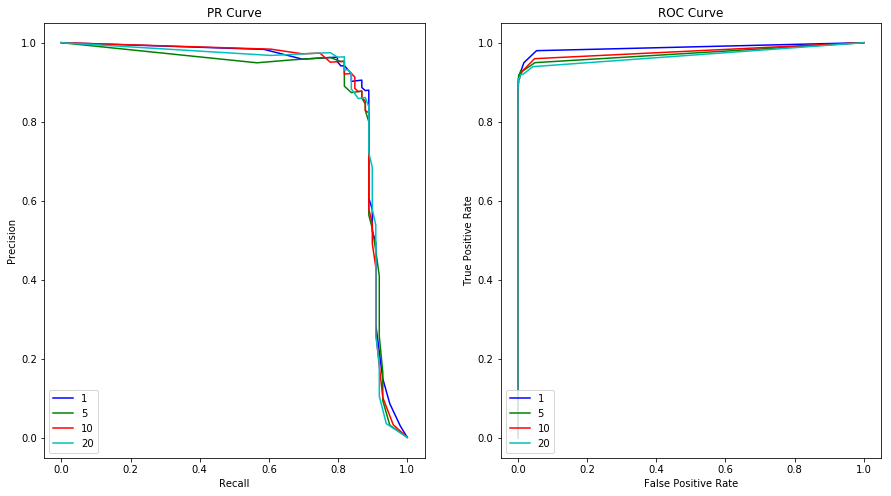

In [24]:
from sklearn.linear_model import LogisticRegression
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20],'bgrcmykw'):
    lr_model = RandomForestClassifier(bootstrap=False,class_weight={0:1,1:w},criterion='entropy',random_state=7,n_estimators=50)

    lr_model.fit(X2,y2)
    pred_prob = lr_model.predict_proba(X)[:,1]

    p,r,_ = precision_recall_curve(y,pred_prob)
    tpr,fpr,_ = roc_curve(y,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

# Undersampling

In [1]:
df = pd.read_csv('C:/Users/VonGola/Downloads/Compressed/creditcard.csv', low_memory=False)
df.head()
df.Class.value_counts()


NameError: name 'pd' is not defined

In [26]:
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)
## we're dropping features that depicts extremely similar distributions of data for both fraud and valid transactions
## As it won't provide any help for our models, and may in fact be only a noise that cloud the signal

In [42]:
# fraud accounts for 0.173047500131896 %
# for the first undersampled dataframe let's up it to 1% i.e. 49200 samples for valid transaction
dfValid=df.drop(df[df.Class==1].index)
dfFraud=df.drop(df[df.Class==0].index)
dfValid=dfValid.sample(frac=0.173047500131896)
frames = [dfFraud, dfValid]
Udf1 = pd.concat(frames)
Udf1.Class.value_counts()

0    49200
1      492
Name: Class, dtype: int64

In [43]:
train, validate, test = np.split(Udf1.sample(frac=1), [int(.6*len(Udf1)), int(.8*len(Udf1))])
print(len(train))
print(len(validate))
print(len(test))

29815
9938
9939


In [44]:
X = test.iloc[:,:-1]
y= test['Class']
X2 = train.iloc[:,:-1]
y2 = train['Class']
Xv=validate.iloc[:,:-1]
yv=validate['Class']

Accuracy: 0.997786497635577
Total test data points: 9939
TP  69
FP  1
TN  9848
FN  21
BCR : BALANCED CLASSIFICATION RATE  0.8832825667580465
total fraud  90
total legit  9849
Recall; percentage of detected fraud  0.7666666666666667
false alarm rate  0.0001015331505736623


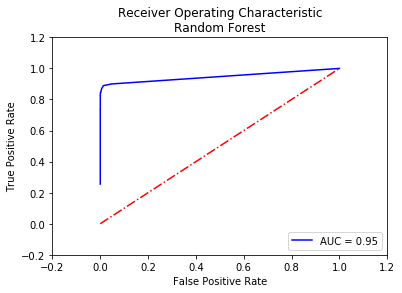

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(bootstrap=True,class_weight='balanced',criterion='entropy',random_state=7,n_estimators=43)
rf.fit(X2,y2)
y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)
predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X) - (false_neg + false_pos)) / len(X)
print("Accuracy:", accuracy)

print("Total test data points:", len(X))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

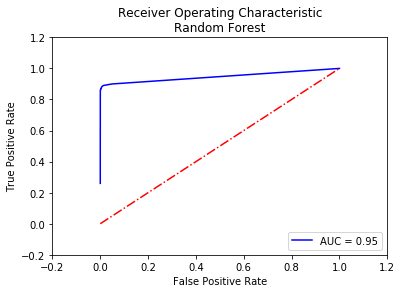

Accuracy: 0.9983900181122962
Total test data points: 9938
TP  86
FP  2
TN  9836
FN  14
BCR : BALANCED CLASSIFICATION RATE  0.9298983533238463
total fraud  100
total legit  9838
Recall; percentage of detected fraud  0.86
false alarm rate  0.00020329335230737954


In [46]:
y_rf=rf.predict(Xv)
y_rf_prob=rf.predict_proba(Xv)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(yv,y_rf_prob)

#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(yv,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(yv == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(yv == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(Xv) - (false_neg + false_pos)) / len(Xv)
print("Accuracy:", accuracy)

print("Total test data points:", len(Xv))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)

Accuracy: 0.9996769742316727
Total test data points: 284807
TP  455
FP  55
TN  284260
FN  37
BCR : BALANCED CLASSIFICATION RATE  0.9623016502793978
total fraud  492
total legit  284315
Recall; percentage of detected fraud  0.9247967479674797
false alarm rate  0.00019344740868403002


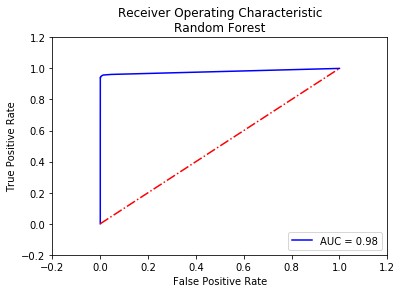

In [47]:
#test with  the entire dataframe
X = df.iloc[:,:-1]
y= df['Class']
y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)
predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X) - (false_neg + false_pos)) / len(X)
print("Accuracy:", accuracy)

print("Total test data points:", len(X))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [5]:
#### Undersampling 2
# fraud accounts for 0.173047500131896 %
# for the second undersampled dataframe let's up it to 10% i.e. 4920 samples for valid transaction
dfValid=df.drop(df[df.Class==1].index)
dfFraud=df.drop(df[df.Class==0].index)
dfValid=dfValid.sample(frac=0.0173047500131896)
frames = [dfFraud, dfValid]
Udf1 = pd.concat(frames)
Udf1.Class.value_counts()

0    4920
1     492
Name: Class, dtype: int64

In [6]:
train, validate = np.split(Udf1.sample(frac=1), [int(.6*len(Udf1))])
print(len(train)/len(Udf1))
print(len(validate)/len(Udf1))

0.5999630450849963
0.4000369549150037


In [37]:
X = test.iloc[:,:-1]
y= test['Class']
X2 = train.iloc[:,:-1]
y2 = train['Class']
Xv=validate.iloc[:,:-1]
yv=validate['Class']

Accuracy: 0.976915974145891
Total test data points: 1083
TP  95
FP  1
TN  963
FN  24
BCR : BALANCED CLASSIFICATION RATE  0.8986409916663761
total fraud  119
total legit  964
Recall; percentage of detected fraud  0.7983193277310925
false alarm rate  0.001037344398340249


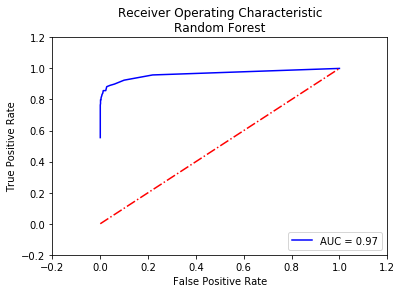

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(bootstrap=True,class_weight='balanced',criterion='entropy',random_state=7,n_estimators=43)
rf.fit(X2,y2)
y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)
predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X) - (false_neg + false_pos)) / len(X)
print("Accuracy:", accuracy)

print("Total test data points:", len(X))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

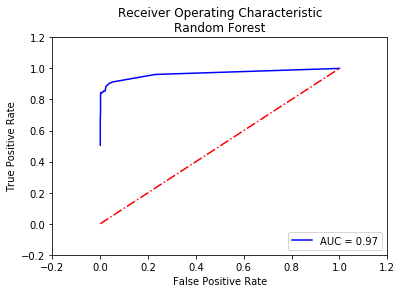

Accuracy: 0.9833641404805915
Total test data points: 1082
TP  86
FP  1
TN  978
FN  17
BCR : BALANCED CLASSIFICATION RATE  0.9169650029255134
total fraud  103
total legit  979
Recall; percentage of detected fraud  0.8349514563106796
false alarm rate  0.0010214504596527069


In [39]:
y_rf=rf.predict(Xv)
y_rf_prob=rf.predict_proba(Xv)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(yv,y_rf_prob)

#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(yv,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(yv == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(yv == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(Xv) - (false_neg + false_pos)) / len(Xv)
print("Accuracy:", accuracy)

print("Total test data points:", len(Xv))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)

Accuracy: 0.998546384042527
Total test data points: 284807
TP  451
FP  373
TN  283942
FN  41
BCR : BALANCED CLASSIFICATION RATE  0.9576773707566139
total fraud  492
total legit  284315
Recall; percentage of detected fraud  0.9166666666666666
false alarm rate  0.0013119251534389673


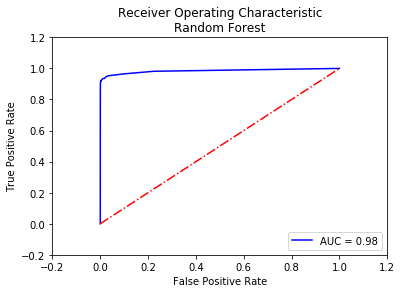

In [40]:
#test with  the entire dataframe
X = df.iloc[:,:-1]
y= df['Class']
y_rf=rf.predict(X)
y_rf_prob=rf.predict_proba(X)[:,1]

#Performance metrics evaluation
auc=metrics.roc_auc_score(y,y_rf_prob)
predictions=y_rf
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))


pred_good = np.where(predictions == 0)[0]
real_good = np.where(y == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))
FP=false_pos
FN=false_neg
TP=len(real_fraud)-FN
TN=len(real_good)-FP
false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X) - (false_neg + false_pos)) / len(X)
print("Accuracy:", accuracy)

print("Total test data points:", len(X))


print("TP ",TP)
print("FP ",FP)
print("TN ",TN)
print("FN ",FN)
recall=TP/float(TP+FN)
ee=TP/float(TP+FN)
tmp=TN/float(TN+FP)
MCC=ee+tmp
MCC=MCC/2
print("BCR : BALANCED CLASSIFICATION RATE ",MCC)
print("total fraud ",TP+FN)
print("total legit ",TN+FP)
print("Recall; percentage of detected fraud ",recall)
far=FP/float(TN+FP)
print("false alarm rate ",far)
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()